Employee attrition information originally provided by IBM Watson Analytics Lab.    
* problem type: supervised binomial classification
* response variable: Attrition (i.e., “Yes”, “No”)
* features: 30
* observations: 1,470
* objective: use employee attributes to predict if they will attrit (leave the company)
* access: provided by the rsample package (Kuhn and Wickham 2019)
* more details: See ?rsample::attrition


In [ ]:
#install.packages("rsample")
#install.packages("h2o")

# Import libraries

In [1]:
# Helper packages
library(dplyr)     # for data manipulation
library(ggplot2)   # for awesome graphics

# Modeling process packages
library(rsample)   # for resampling procedures
library(caret)     # for resampling and model training
library(h2o)       # for resampling and model training

# h2o set-up 
h2o.no_progress()  # turn off h2o progress bars
h2o.init()         # launch h2o


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: ‘h2o’


The following objects are masked from ‘package:stats’:

    cor, sd, var


The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc




 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 hours 4 minutes 
    H2O cluster timezone:       America/Montevideo 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.30.1.3 
    H2O cluster version age:    10 days  
    H2O cluster name:           H2O_started_from_R_creyesp_osn291 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   2.36 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 3.6.3 (2020-02-29) 



# Load Dataset

In [27]:
data("attrition", package = "modeldata")


In [28]:
# Job attrition data
attrition <- attrition %>% 
  mutate_if(is.ordered, .funs = factor, ordered = FALSE)
attrition_h2o <- as.h2o(attrition)

Warning message in use.package("data.table"):
“data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups.”


In [29]:
# initial dimension
dim(attrition)

[1] 1470   31

In [30]:
# response variable
head(attrition)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,⋯,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<fct>,<fct>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<int>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,1102,Sales,1,College,Life_Sciences,Medium,Female,⋯,Excellent,Low,0,8,0,Bad,6,4,0,5
2,49,No,Travel_Frequently,279,Research_Development,8,Below_College,Life_Sciences,High,Male,⋯,Outstanding,Very_High,1,10,3,Better,10,7,1,7
3,37,Yes,Travel_Rarely,1373,Research_Development,2,College,Other,Very_High,Male,⋯,Excellent,Medium,0,7,3,Better,0,0,0,0
4,33,No,Travel_Frequently,1392,Research_Development,3,Master,Life_Sciences,Very_High,Female,⋯,Excellent,High,0,8,3,Better,8,7,3,0
5,27,No,Travel_Rarely,591,Research_Development,2,Below_College,Medical,Low,Male,⋯,Excellent,Very_High,1,6,3,Better,2,2,2,2
6,32,No,Travel_Frequently,1005,Research_Development,2,College,Life_Sciences,Very_High,Male,⋯,Excellent,High,0,8,2,Good,7,7,3,6


## Splittin dataset

In [40]:
initial_split(data = attrition, prop = 0.7)

<Analysis/Assess/Total>
<1029/441/1470>

In [43]:
# Using base R
set.seed(123)  # for reproducibility
index_1 <- sample(1:nrow(attrition), round(nrow(attrition) * 0.7))
train_base_ <- attrition[index_1, ]
test_base  <- attrition[-index_1, ]

# Using caret package

index_caret <- createDataPartition(attrition$Attrition, p = 0.7, list = FALSE)
train_caret <- attrition[index_caret, ]
test_caret  <- attrition[-index_caret, ]

# Using rsample package
split_1  <- initial_split(data = attrition, prop = 0.7, strata = "Attrition")
train_3  <- training(split_1)
test_3   <- testing(split_1)

# Using h2o package
split_2 <- h2o.splitFrame(attrition_h2o, ratios = 0.7, seed = 123)
train_4 <- split_2[[1]]
test_4  <- split_2[[2]]

# EDA

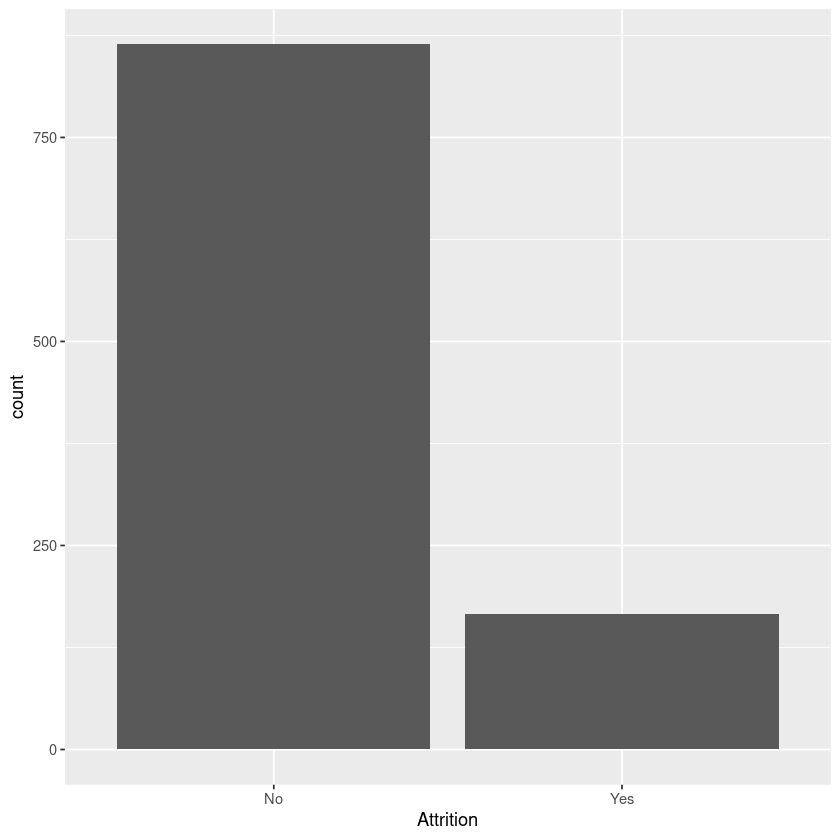

In [45]:
ggplot(train_caret, aes(x=Attrition)) + geom_bar()

In [53]:
train_caret %>% 
    count(Attrition) %>%
    mutate(perc = n / nrow(train_caret))

Attrition,n,perc
<fct>,<int>,<dbl>
No,864,0.838835
Yes,166,0.161165


In [55]:
test_caret %>% 
    count(Attrition) %>%
    mutate(perc = n / nrow(test_caret))

Attrition,n,perc
<fct>,<int>,<dbl>
No,369,0.8386364
Yes,71,0.1613636


# Modeling
R tiene un aplio abanico de librerias que implementan diferentes tipos de modelos e incluso varias implementaciones del mismo modelo pero con diferentes enfoques. Ademas de estos hay librerias que unifican estas para agilizar el proceso de modelo y standarizar los procesos.

Hay diferentes formas de como se deben pasar la data para entrenar un modelo:
* Clasica de R usando una formula como una expresion sombolica de la relacion de dependencia 
    * `fn(Y ~ X)`
* usando separadamente $Y$, $X$ como argumentos independientes
    * `fn(x = ames[, features], y = ames$Sale_Price)`
* usando separadamente $Y$, $X$ pero pasando solo el nombre de las variables de un dataframe 
    * `fn(x = c("Year_Sold", "Longitude", "Latitude"), y = "Sale_Price", data = ames.h2o)`



## Engines
Como se mencion anteriormente hay varias librerias que implementan por ejemplo el mismo modelo pero con diferente sabpres, estos son conocidos como "engines"

### Logistic Regression
<img src='https://static.javatpoint.com/tutorial/machine-learning/images/linear-regression-vs-logistic-regression.png'>

In [ ]:
lm_glm <- glm(Attrition ~ ., data = train_2, family = "binomial")
summary(lm_glm)

In [ ]:
lm_caret  <- train(Attrition ~ ., data = train_2,   method = "rf", family = "binomial")

In [ ]:
lm_caret

In [ ]:
pred = predict(lm_caret, newdata = test_2)
table(pred, test_2$Attrition)


In [ ]:
pred = predict(lm_caret, newdata = test_2, type = "prob")

In [ ]:
head(pred)

In [ ]:
ggplot(pred, aes(Yes) ) + geom_histogram()

In [ ]:
y = as.numeric(test_2$Attrition) - 1 
calibrate.plot(y, pred$Yes, )


In [ ]:
install.packages("gbm")


In [ ]:
library(gbm)